# Axona to NWB

Convert Axona raw (`.bin` + `.set`) or unit data (`.X`, `.pos`, `.eeg`, `.egf`) to NWB format. 

It might be handy to convert the position data in the `.bin` file to a `.pos` file, allowing us to use the same code for both axona formats, as well as the Intan format later on (requiring the Hussaini lab to create their own `.pos` files based on the position tracking used). 

### Axona raw (`.bin` + `.set`)

In [61]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
from pathlib import Path

# Old .bin file
base_dir = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/')
dir_name = base_dir / 'example_data_raw'
base_filename = '20201004_Raw'

# New .bin file
base_dir = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data')
dir_name = base_dir / '06172021-HPC-B6-RAW'
base_filename = '06172021-HPC-B6-RAW'
filename = os.path.join(dir_name, base_filename)
set_file = filename + '.set'
bin_file = filename + '.bin'
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW


In [63]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface, AxonaPositionDataInterface
)

In [64]:
class HussainiAxonaNWBConverter(NWBConverter):
    data_interface_classes = dict(
        AxonaRecordingExtractorInterface=AxonaRecordingExtractorInterface,
        AxonaPositionDataInterface=AxonaPositionDataInterface
    )

In [65]:
import random
import string
from typing import Union, Optional
from pathlib import Path
import spikeextractors as se
from pynwb import NWBFile
import numpy as np
import re
import datetime
import json
from jsonschema import validate, ValidationError

from nwb_conversion_tools.utils.json_schema import get_schema_from_method_signature, get_base_schema, fill_defaults
from nwb_conversion_tools import SpikeGLXRecordingInterface

In [66]:
# Specify source data

source_data = dict(
    AxonaPositionDataInterface=dict(
        filename=set_file
    ),
    AxonaRecordingExtractorInterface=dict(
        filename=set_file
    )
)
print(json.dumps(source_data, indent=2))

{
  "AxonaPositionDataInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  },
  "AxonaRecordingExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  }
}


In [67]:
# Initialize HussainiAxonaNWBConverter

converter = HussainiAxonaNWBConverter(source_data=source_data)

Source data is valid!


In [68]:
# Get metadata

metadata = converter.get_metadata()
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': 'bffa7e03-c9ac-4bc3-bb39-afc8f11ea265',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [69]:
# Get metadata_schema from converter

metadata_schema = converter.get_metadata_schema()

print(json.dumps(metadata_schema['properties'], indent=2))

{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": ""
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "91f77e71-a736-4592-a08a-0c3fdd01f32a"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "2021-06-17T12:22:02"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment",
        "default": [
          "Abid"
        ]
      },
      "e

In [70]:
# Validate metadata against metadata_schema

validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

In [71]:
converter.get_metadata()

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': 'c43cc739-ca41-46a0-b47f-35b023118410',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [72]:
from nwb_conversion_tools.utils.conversion_tools import (
    get_default_nwbfile_metadata, make_nwbfile_from_metadata
)

In [73]:
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': 'bffa7e03-c9ac-4bc3-bb39-afc8f11ea265',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [74]:
output_file = base_dir / 'out_example.nwb'

In [75]:
# Export to NWB file

output_file = base_dir / 'out_example.nwb'

converter.run_conversion(
    metadata=metadata, 
    nwbfile_path=output_file,
    overwrite=True,
    save_to_file=True,
    conversion_options=None
)

Metadata is valid!


/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/hdmf/build/objectmapper.py:256: DtypeConversionWarning: Spec 'SpatialSeries/timestamps': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)


NWB file saved at /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/out_example.nwb!


In [76]:
# Check NWB file

from pynwb import NWBHDF5IO

fname = output_file
with NWBHDF5IO(fname, 'r') as io:
    nwbfile = io.read()
    print(nwbfile)

root pynwb.file.NWBFile at 0x139932629529264
Fields:
  acquisition: {
    ElectricalSeries_raw <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Axona <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Group0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group3 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Abid']
  file_create_date: [datetime.datetime(2021, 7, 23, 10, 35, 6, 787702, tzinfo=tzoffset(None, 7200))]
  identifier: bffa7e03-c9ac-4bc3-bb39-afc8f11ea265
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  session_start_time: 2021-06-17 12:22:02+02:00
  timestamps_reference_time: 2021-06-17 12:22:02+02:00



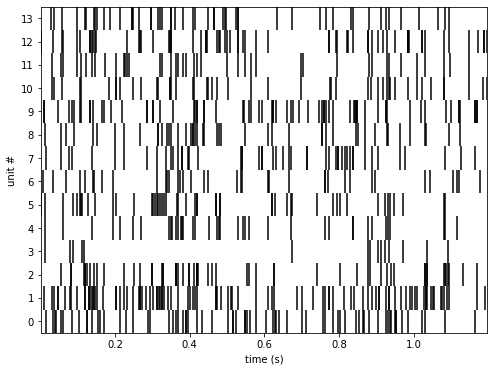

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt


from nwbwidgets import nwb2widget

output_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/nwb/axona_se_MS4.nwb'
#output_file = '/mnt/d/NWB/data/NWBData/NWBData/P9HMH_NOID5.nwb'

io = NWBHDF5IO(output_file, mode='r')
nwb = io.read()

nwb2widget(nwb)

In [46]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import get_position_object

pos = get_position_object(filename=set_file)

In [47]:
nwb.processing['behavior'].data_interfaces['Position'].spatial_series['t'].data

<HDF5 dataset "data": shape (59965,), type "<f8">

In [51]:
pos.spatial_series['t'].timestamps

array([6.25000000e-02, 8.75000000e-01, 6.37500000e+00, ...,
       5.99976375e+05, 5.99986375e+05, 5.99996375e+05])

### Parse `.pos` files

In [128]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import parse_generic_header

# Old pos file
pos_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/axona_sample.pos'

# New pos file
pos_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos'
print(pos_file)

pos_header = parse_generic_header(pos_file, None)
pos_header

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos


{'trial_date': 'Thursday, 17 Jun 2021',
 'trial_time': '12:22:02',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '301',
 'sw_version': '1.2.2.16',
 'num_colours': '4',
 'min_x': '0',
 'max_x': '640',
 'min_y': '0',
 'max_y': '480',
 'window_min_x': '247',
 'window_max_x': '426',
 'window_min_y': '179',
 'window_max_y': '357',
 'timebase': '50 hz',
 'bytes_per_timestamp': '4',
 'sample_rate': '50.0 hz',
 'EEG_samples_per_position': '5',
 'bearing_colour_1': '0',
 'bearing_colour_2': '0',
 'bearing_colour_3': '0',
 'bearing_colour_4': '0',
 'pos_format': 't,x1,y1,x2,y2,numpix1,numpix2',
 'bytes_per_coord': '2',
 'pixels_per_metre': '300',
 'num_pos_samples': '15050'}

Data (with memory map)

In [129]:
def get_header_bstring(file):
    """
    Scan file for the occurrence of 'data_start' and return the header
    as byte string

    Parameters
    ----------
    file (str or path): file to be loaded

    Returns
    -------
    str: header byte content
    """

    header = b''
    with open(file, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                header += b'data_start'
                break
            else:
                header += bin_line
    return header

In [130]:
with open(pos_file, 'rb') as f:
    print(f.read(532))
    print(f.read(1))

b'trial_date Thursday, 17 Jun 2021\r\ntrial_time 12:22:02\r\nexperimenter Abid\r\ncomments \r\nduration 301       \r\nsw_version 1.2.2.16\r\nnum_colours 4\r\nmin_x 0\r\nmax_x 640\r\nmin_y 0\r\nmax_y 480\r\nwindow_min_x 247\r\nwindow_max_x 426\r\nwindow_min_y 179\r\nwindow_max_y 357\r\ntimebase 50 hz\r\nbytes_per_timestamp 4\r\nsample_rate 50.0 hz\r\nEEG_samples_per_position 5\r\nbearing_colour_1 0\r\nbearing_colour_2 0\r\nbearing_colour_3 0\r\nbearing_colour_4 0\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2\r\nbytes_per_coord 2\r\npixels_per_metre 300\r\nnum_pos_samples 15050     \r'
b'\n'


# Intan to NWB

For this there are already resources from the Hussaini lab we should be able to use.

See here: ...

In [39]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface, AxonaPositionDataInterface, IntanRecordingInterface
)

In [40]:
from nwb_conversion_tools import IntanRecordingInterface

In [41]:
class HussainiIntanNWBConverter(NWBConverter):
    data_interface_classes = dict(
        IntanRecordingInterface=IntanRecordingInterface,
    )

In [42]:
intan_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd'

In [43]:
# Specify source data

source_data = dict(
    IntanRecordingInterface=dict(
        file_path=intan_file
    )
)
print(json.dumps(source_data, indent=2))

{
  "IntanRecordingInterface": {
    "file_path": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd"
  }
}


In [44]:
# Initialize HussainiIntanNWBConverter

intan_converter = HussainiIntanNWBConverter(source_data=source_data)

Source data is valid!


In [45]:
# Get metadata_schema from converter

metadata_schema = intan_converter.get_metadata_schema()

print(json.dumps(metadata_schema['properties'], indent=2))

{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": "no description"
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "74a1b10c-84a8-4a5f-8a2d-9ea071e282b4"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "1970-01-01T00:00:00"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment"
      },
      "experiment_description": {
        "

In [46]:
# Validate metadata against metadata_schema

validate(
    instance=intan_converter.get_metadata(),
    schema=intan_converter.get_metadata_schema()
)

ValidationError: Additional properties are not allowed ('ElectricalSeries_raw' was unexpected)

Failed validating 'additionalProperties' in schema['properties']['Ecephys']:
    {'additionalProperties': False,
     'properties': {'Device': {'default': [{}],
                               'items': {'$ref': '#/properties/Ecephys/properties/definitions/Device'},
                               'minItems': 1,
                               'type': 'array'},
                    'ElectrodeGroup': {'default': [{'description': 'Group '
                                                                   'B '
                                                                   'electrodes.',
                                                    'name': 'GroupB'},
                                                   {'description': 'Group '
                                                                   'A '
                                                                   'electrodes.',
                                                    'name': 'GroupA'},
                                                   {'description': 'Group '
                                                                   'C '
                                                                   'electrodes.',
                                                    'name': 'GroupC'}],
                                       'items': {'$ref': '#/properties/Ecephys/properties/definitions/ElectrodeGroup'},
                                       'minItems': 1,
                                       'type': 'array'},
                    'Electrodes': {'default': [{'description': 'The name '
                                                               'of the '
                                                               'ElectrodeGroup '
                                                               'this '
                                                               'electrode '
                                                               'is a part '
                                                               'of.',
                                                'name': 'group_name'},
                                               {'data': [[0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63,
                                                          0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63,
                                                          0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63]],
                                                'description': '0-indexed '
                                                               'channel '
                                                               'within a '
                                                               'group.',
                                                'name': 'group_electrode_number'},
                                               {'data': ['F1-01',
                                                         'F1-02',
                                                         'F1-03',
                                                         'F1-04',
                                                         'F1-05',
                                                         'F1-06',
                                                         'F1-07',
                                                         'F1-08',
                                                         'F1-09',
                                                         'F1-10',
                                                         'F1-11',
                                                         'F1-12',
                                                         'F1-13',
                                                         'F1-14',
                                                         'F1-15',
                                                         'F1-16',
                                                         'F1-17',
                                                         'F1-18',
                                                         'F1-19',
                                                         'F1-20',
                                                         'F1-21',
                                                         'F1-22',
                                                         'F1-23',
                                                         'F1-24',
                                                         'F1-25',
                                                         'F1-26',
                                                         'F1-27',
                                                         'F1-28',
                                                         'F1-29',
                                                         'F1-30',
                                                         'F1-31',
                                                         'F1-32',
                                                         'F5(HAND)-01',
                                                         'F5(HAND)-02',
                                                         'F5(HAND)-03',
                                                         'F5(HAND)-04',
                                                         'F5(HAND)-05',
                                                         'F5(HAND)-06',
                                                         'F5(HAND)-07',
                                                         'F5(HAND)-08',
                                                         'F5(hand)-09',
                                                         'F5(HAND)-10',
                                                         'F5(HAND)-11',
                                                         'F5(HAND)-12',
                                                         'F5(HAND)-13',
                                                         'F5(HAND)-14',
                                                         'F5(HAND)-15',
                                                         'F5(HAND)-16',
                                                         'F5(HAND)-17',
                                                         'F5(HAND)-18',
                                                         'F5(HAND)-19',
                                                         'F5(HAND)-20',
                                                         'F5(HAND)-21',
                                                         'F5(HAND)-22',
                                                         'F5(HAND)-23',
                                                         'F5(HAND)-24',
                                                         'F5(HAND)-25',
                                                         'F5(HAND)-26',
                                                         'F5(HAND)-27',
                                                         'F5(HAND)-28',
                                                         'F5(HAND)-29',
                                                         'F5(HAND)-30',
                                                         'F5(HAND)-31',
                                                         'F5(HAND)-32',
                                                         'F5(MOUTH)-01',
                                                         'F5(MOUTH)-02',
                                                         'F5(MOUTH)-03',
                                                         'F5(MOUTH)-04',
                                                         'F5(MOUTH)-05',
                                                         'F5(MOUTH)-06',
                                                         'F5(MOUTH)-07',
                                                         'F5(MOUTH)-08',
                                                         'F5(MOUTH)-09',
                                                         'F5(MOUTH)-10',
                                                         'F5(MOUTH)-11',
                                                         'F5(MOUTH)-12',
                                                         'F5(MOUTH)-13',
                                                         'F5(MOUTH)-14',
                                                         'F5(MOUTH)-15',
                                                         'F5(MOUTH)-16',
                                                         'F5(MOUTH)-17',
                                                         'F5(MOUTH)-18',
                                                         'F5(MOUTH)-19',
                                                         'F5(MOUTH)-20',
                                                         'F5(MOUTH)-21',
                                                         'F5(MOUTH)-22',
                                                         'F5(MOUTH)-23',
                                                         'F5(MOUTH)-24',
                                                         'F5(MOUTH)-25',
                                                         'F5(MOUTH)-26',
                                                         'F5(MOUTH)-27',
                                                         'F5(MOUTH)-28',
                                                         'F5(MOUTH)-29',
                                                         'F5(MOUTH)-30',
                                                         'F5(MOUTH)-31',
                                                         'F5(MOUTH)-32',
                                                         '46v/12r-01',
                                                         '46v/12r-02',
                                                         '46v/12r-03',
                                                         '46v/12r-04',
                                                         '46v/12r-05',
                                                         '46v/12r-06',
                                                         '46v/12r-07',
                                                         '46v/12r-08',
                                                         '46v/12r-09',
                                                         '46v/12r-10',
                                                         '46v/12r-11',
                                                         '46v/12r-12',
                                                         '46v/12r-13',
                                                         '46v/12r-14',
                                                         '46v/12r-15',
                                                         '46v/12r-16',
                                                         '46v/12r-17',
                                                         '46v/12r-18',
                                                         '46v/12r-19',
                                                         '46v/12r-20',
                                                         '46v/12r-21',
                                                         '46v/12r-22',
                                                         '46v/12r-23',
                                                         '46v/12r-24',
                                                         '46v/12r-25',
                                                         '46v/12r-26',
                                                         '46v/12r-27',
                                                         '46v/12r-28',
                                                         '46v/12r-29',
                                                         '46v/12r-30',
                                                         '46v/12r-31',
                                                         '46v/12r-32',
                                                         '45A-01',
                                                         '45A-02',
                                                         '45A-03',
                                                         '45A-04',
                                                         '45A-05',
                                                         '45A-06',
                                                         '45A-07',
                                                         '45A-08',
                                                         '45A-09',
                                                         '45A-10',
                                                         '45A-11',
                                                         '45A-12',
                                                         '45A-13',
                                                         '45A-14',
                                                         '45A-15',
                                                         '45A-16',
                                                         '45A-17',
                                                         '45A-18',
                                                         '45A-19',
                                                         '45A-20',
                                                         '45A-21',
                                                         '45A-22',
                                                         '45A-23',
                                                         '45A-24',
                                                         '45A-25',
                                                         '45A-26',
                                                         '45A-27',
                                                         '45A-28',
                                                         '45A-29',
                                                         '45A-30',
                                                         '45A-31',
                                                         '45A-32',
                                                         'F2-01',
                                                         'F2-02',
                                                         'F2-03',
                                                         'F2-04',
                                                         'F2-05',
                                                         'F2-06',
                                                         'F2-07',
                                                         'F2-08',
                                                         'F2-09',
                                                         'F2-10',
                                                         'F2-11',
                                                         'F2-12',
                                                         'F2-13',
                                                         'F2-14',
                                                         'F2-15',
                                                         'F2-16',
                                                         'F2-17',
                                                         'F2-18',
                                                         'F2-19',
                                                         'F2-20',
                                                         'F2-21',
                                                         'F2-22',
                                                         'F2-23',
                                                         'F2-24',
                                                         'F2-25',
                                                         'F2-26',
                                                         'F2-27',
                                                         'F2-28',
                                                         'F2-29',
                                                         'F2-30',
                                                         'F2-31',
                                                         'F2-32'],
                                                'description': 'Custom '
                                                               'channel '
                                                               'name '
                                                               'assigned '
                                                               'in Intan.',
                                                'name': 'custom_channel_name'}],
                                   'items': {'$ref': '#/properties/Ecephys/properties/definitions/Electrodes'},
                                   'minItems': 0,
                                   'renderForm': False,
                                   'type': 'array'},
                    'definitions': {'Device': {'additionalProperties': False,
                                               'properties': {'description': {'description': 'Description '
                                                                                             'of '
                                                                                             'the '
                                                                                             'device '
                                                                                             '(e.g., '
                                                                                             'model, '
                                                                                             'firmware '
                                                                                             'version, '
                                                                                             'processing '
                                                                                             'software '
                                                                                             'version, '
                                                                                             'etc.)',
                                                                              'type': 'string'},
                                                              'manufacturer': {'description': 'the '
                                                                                              'name '
                                                                                              'of '
                                                                                              'the '
                                                                                              'manufacturer '
                                                                                              'of '
                                                                                              'this '
                                                                                              'device',
                                                                               'type': 'string'},
                                                              'name': {'description': 'the '
                                                                                      'name '
                                                                                      'of '
                                                                                      'this '
                                                                                      'device',
                                                                       'type': 'string'}},
                                               'required': ['name'],
                                               'tag': 'pynwb.device.Device',
                                               'type': 'object'},
                                    'ElectrodeGroup': {'additionalProperties': False,
                                                       'properties': {'description': {'description': 'description '
                                                                                                     'of '
                                                                                                     'this '
                                                                                                     'electrode '
                                                                                                     'group',
                                                                                      'type': 'string'},
                                                                      'device': {'description': 'the '
                                                                                                'device '
                                                                                                'that '
                                                                                                'was '
                                                                                                'used '
                                                                                                'to '
                                                                                                'record '
                                                                                                'from '
                                                                                                'this '
                                                                                                'electrode '
                                                                                                'group',
                                                                                 'target': 'pynwb.device.Device',
                                                                                 'type': 'string'},
                                                                      'location': {'description': 'description '
                                                                                                  'of '
                                                                                                  'location '
                                                                                                  'of '
                                                                                                  'this '
                                                                                                  'electrode '
                                                                                                  'group',
                                                                                   'type': 'string'},
                                                                      'name': {'description': 'the '
                                                                                              'name '
                                                                                              'of '
                                                                                              'this '
                                                                                              'electrode',
                                                                               'type': 'string'}},
                                                       'required': ['location',
                                                                    'name',
                                                                    'description',
                                                                    'device'],
                                                       'tag': 'pynwb.ecephys.ElectrodeGroup',
                                                       'type': 'object'},
                                    'Electrodes': {'additionalProperties': False,
                                                   'properties': {'description': {'description': 'description '
                                                                                                 'of '
                                                                                                 'this '
                                                                                                 'electrodes '
                                                                                                 'column',
                                                                                  'type': 'string'},
                                                                  'name': {'description': 'name '
                                                                                          'of '
                                                                                          'this '
                                                                                          'electrodes '
                                                                                          'column',
                                                                           'type': 'string'}},
                                                   'required': ['name'],
                                                   'type': 'object'}}},
     'required': ['Device', 'ElectrodeGroup'],
     'tag': 'Ecephys',
     'type': 'object'}

On instance['Ecephys']:
    {'Device': [{}],
     'ElectricalSeries_raw': {'description': 'Raw acquisition traces.',
                              'name': 'ElectricalSeries_raw'},
     'ElectrodeGroup': [{'description': 'Group B electrodes.',
                         'name': 'GroupB'},
                        {'description': 'Group A electrodes.',
                         'name': 'GroupA'},
                        {'description': 'Group C electrodes.',
                         'name': 'GroupC'}],
     'Electrodes': [{'description': 'The name of the ElectrodeGroup this '
                                    'electrode is a part of.',
                     'name': 'group_name'},
                    {'data': [[0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63,
                               0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63,
                               0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63]],
                     'description': '0-indexed channel within a group.',
                     'name': 'group_electrode_number'},
                    {'data': ['F1-01',
                              'F1-02',
                              'F1-03',
                              'F1-04',
                              'F1-05',
                              'F1-06',
                              'F1-07',
                              'F1-08',
                              'F1-09',
                              'F1-10',
                              'F1-11',
                              'F1-12',
                              'F1-13',
                              'F1-14',
                              'F1-15',
                              'F1-16',
                              'F1-17',
                              'F1-18',
                              'F1-19',
                              'F1-20',
                              'F1-21',
                              'F1-22',
                              'F1-23',
                              'F1-24',
                              'F1-25',
                              'F1-26',
                              'F1-27',
                              'F1-28',
                              'F1-29',
                              'F1-30',
                              'F1-31',
                              'F1-32',
                              'F5(HAND)-01',
                              'F5(HAND)-02',
                              'F5(HAND)-03',
                              'F5(HAND)-04',
                              'F5(HAND)-05',
                              'F5(HAND)-06',
                              'F5(HAND)-07',
                              'F5(HAND)-08',
                              'F5(hand)-09',
                              'F5(HAND)-10',
                              'F5(HAND)-11',
                              'F5(HAND)-12',
                              'F5(HAND)-13',
                              'F5(HAND)-14',
                              'F5(HAND)-15',
                              'F5(HAND)-16',
                              'F5(HAND)-17',
                              'F5(HAND)-18',
                              'F5(HAND)-19',
                              'F5(HAND)-20',
                              'F5(HAND)-21',
                              'F5(HAND)-22',
                              'F5(HAND)-23',
                              'F5(HAND)-24',
                              'F5(HAND)-25',
                              'F5(HAND)-26',
                              'F5(HAND)-27',
                              'F5(HAND)-28',
                              'F5(HAND)-29',
                              'F5(HAND)-30',
                              'F5(HAND)-31',
                              'F5(HAND)-32',
                              'F5(MOUTH)-01',
                              'F5(MOUTH)-02',
                              'F5(MOUTH)-03',
                              'F5(MOUTH)-04',
                              'F5(MOUTH)-05',
                              'F5(MOUTH)-06',
                              'F5(MOUTH)-07',
                              'F5(MOUTH)-08',
                              'F5(MOUTH)-09',
                              'F5(MOUTH)-10',
                              'F5(MOUTH)-11',
                              'F5(MOUTH)-12',
                              'F5(MOUTH)-13',
                              'F5(MOUTH)-14',
                              'F5(MOUTH)-15',
                              'F5(MOUTH)-16',
                              'F5(MOUTH)-17',
                              'F5(MOUTH)-18',
                              'F5(MOUTH)-19',
                              'F5(MOUTH)-20',
                              'F5(MOUTH)-21',
                              'F5(MOUTH)-22',
                              'F5(MOUTH)-23',
                              'F5(MOUTH)-24',
                              'F5(MOUTH)-25',
                              'F5(MOUTH)-26',
                              'F5(MOUTH)-27',
                              'F5(MOUTH)-28',
                              'F5(MOUTH)-29',
                              'F5(MOUTH)-30',
                              'F5(MOUTH)-31',
                              'F5(MOUTH)-32',
                              '46v/12r-01',
                              '46v/12r-02',
                              '46v/12r-03',
                              '46v/12r-04',
                              '46v/12r-05',
                              '46v/12r-06',
                              '46v/12r-07',
                              '46v/12r-08',
                              '46v/12r-09',
                              '46v/12r-10',
                              '46v/12r-11',
                              '46v/12r-12',
                              '46v/12r-13',
                              '46v/12r-14',
                              '46v/12r-15',
                              '46v/12r-16',
                              '46v/12r-17',
                              '46v/12r-18',
                              '46v/12r-19',
                              '46v/12r-20',
                              '46v/12r-21',
                              '46v/12r-22',
                              '46v/12r-23',
                              '46v/12r-24',
                              '46v/12r-25',
                              '46v/12r-26',
                              '46v/12r-27',
                              '46v/12r-28',
                              '46v/12r-29',
                              '46v/12r-30',
                              '46v/12r-31',
                              '46v/12r-32',
                              '45A-01',
                              '45A-02',
                              '45A-03',
                              '45A-04',
                              '45A-05',
                              '45A-06',
                              '45A-07',
                              '45A-08',
                              '45A-09',
                              '45A-10',
                              '45A-11',
                              '45A-12',
                              '45A-13',
                              '45A-14',
                              '45A-15',
                              '45A-16',
                              '45A-17',
                              '45A-18',
                              '45A-19',
                              '45A-20',
                              '45A-21',
                              '45A-22',
                              '45A-23',
                              '45A-24',
                              '45A-25',
                              '45A-26',
                              '45A-27',
                              '45A-28',
                              '45A-29',
                              '45A-30',
                              '45A-31',
                              '45A-32',
                              'F2-01',
                              'F2-02',
                              'F2-03',
                              'F2-04',
                              'F2-05',
                              'F2-06',
                              'F2-07',
                              'F2-08',
                              'F2-09',
                              'F2-10',
                              'F2-11',
                              'F2-12',
                              'F2-13',
                              'F2-14',
                              'F2-15',
                              'F2-16',
                              'F2-17',
                              'F2-18',
                              'F2-19',
                              'F2-20',
                              'F2-21',
                              'F2-22',
                              'F2-23',
                              'F2-24',
                              'F2-25',
                              'F2-26',
                              'F2-27',
                              'F2-28',
                              'F2-29',
                              'F2-30',
                              'F2-31',
                              'F2-32'],
                     'description': 'Custom channel name assigned in '
                                    'Intan.',
                     'name': 'custom_channel_name'}]}